**Here we explore a data a bit and try to understand it better. First we import the requried packages and read and format the data.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample
from datetime import datetime
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score
sns.set(color_codes=True)
%matplotlib inline

def to_date_time(data, column_name):
    data[column_name] = [
    datetime(int(x.split('-')[0]), 
             int(x.split('-')[1]), 
             int(x.split('-')[2])) for x in data[column_name]
    ]
    return data

def data_transformer(data, departure_dates, indexes, detrend=True):
    reshaped_data = pd.DataFrame(index=indexes, columns=departure_dates, data=None)
    for departure_date in departure_dates:
        sales_per_day_for_departure = data[
            data.flight_departure_date==departure_date]['tickets_sold_by_snapshot_date']
        if detrend:
            sales_per_day_for_departure = (
                sales_per_day_for_departure - sales_per_day_for_departure.shift(1).fillna(0)
            )
        sales_per_day_for_departure = sales_per_day_for_departure.values
        index = data[
            data.flight_departure_date==departure_date]['snapshot_date'].values
        column = pd.Series(data=sales_per_day_for_departure, index=index)
        reshaped_data[departure_date]=column
    return reshaped_data

We read the csv file, and convret its date columns from string to python datetime to facilitate the usage of date related methods. Since we are dealing with time series data, we also have try to remove the trend out of the ticket sales to see how many tickets have been sold on each day.

In [2]:
data = pd.read_csv("sales_data.csv")
data = to_date_time(data, 'snapshot_date')
data = to_date_time(data, 'flight_departure_date')
data = data.sort_values(['flight_departure_date','snapshot_date'], ascending=[True,True])

departure_dates = sorted(list(set(data.flight_departure_date)))
indexes = sorted(list(set(data.snapshot_date)))
data_reshaped_dtrend = data_transformer(data, departure_dates, indexes)
data_reshaped = data_transformer(data, departure_dates, indexes, False)

We randomly plot the data for 10 different departure dates to see how they look like in general. We plot the data for these 10 departure dates both with the trend (cumulative sum of tickets sold by the snapshot date) and without the trend.

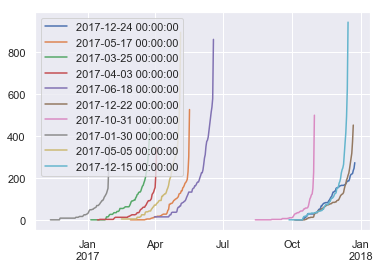

In [3]:
departures_sample = sample(departure_dates, 10)
data_reshaped[departures_sample].plot()

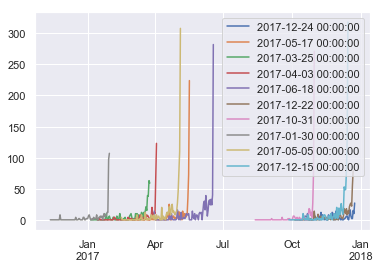

In [4]:
data_reshaped_dtrend[departures_sample].plot()

First important observation is that the data from the beginning does not provide enough information on how many tickets will get sold by the departure date as the sales increase significantly towards the end of the selling period.

Based on this fact, we should come up and engineer new metadata. But first, we transform the data into a pandas dataframe with 365 rows and 80 columns which can be fed into supervised learning algorithms as the training data matrix. Each row has the information for a specific departure date with tickets sold on each snapshot date.

In [5]:
column_vec = ["day " + str(x) for x in range(1,80)]
column_vec.append('y')
data_supervised = pd.DataFrame(columns=column_vec, dtype='int64')
for departure_date in departure_dates:
    tickets_by_day = list(
        data[data.flight_departure_date==departure_date]['tickets_sold_by_snapshot_date'].values)
    tickets_per_day = [tickets_by_day[i+1] - tickets_by_day[i] for i in range(78)]
    tickets_per_day = [tickets_by_day[0]] + tickets_per_day + [tickets_by_day[-1]]
    data_supervised.loc[departure_date] = tickets_per_day

In [6]:
dates = pd.DatetimeIndex(data_supervised.index.values)
y = data_supervised.y

Next we will add some feature engineering by adding additional temporal characteristics based on the departure date. Including which day of the week the flight leaves (Mon-Sun), day of the month, month (1-12).

In [7]:
X = data_supervised[data_supervised.columns.values[:-1]]
X = X.assign(quarter_start=dates.is_quarter_start)
X = X.assign(quarter_end=dates.is_quarter_end)
X = X.assign(month_start=dates.is_month_start)
X = X.assign(month_end=dates.is_month_end)
X = X.assign(dayofyear=dates.day)
X = X.assign(weekofyear=dates.weekofyear)
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(np.array(dates.dayofweek).reshape(-1,1))
dayofweek = enc.transform(np.array(dates.dayofweek).reshape(-1,1)).toarray()
enc = OneHotEncoder()
enc.fit(np.array(dates.month).reshape(-1,1))
month = enc.transform(np.array(dates.month).reshape(-1,1)).toarray()

min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X)
X_train = np.concatenate((X_train, dayofweek, month), axis=1)
X = pd.DataFrame(X_train, index=X.index)

We check 5 different models and compute the 10-fold cross validation score to see which one performs the best. We train each model 79 times for the data that is available up to each snapshot as we get closer to the departure date to see how they perform along the interval.

In [8]:
predicted_ridge = list()
predicted_svr = list()
predicted_rf = list()
predicted_ada = list()
predicted_gbr = list()

for i in range(79):
    if i%10==0:
        print(i, end=" ")
    columns = list(range(i+1)) + list(range(79, 104))
    X_train = X[X.columns[columns]]

    ridge = linear_model.Ridge(alpha = .5)
    scores = cross_val_score(ridge, X_train, y, cv=10, scoring='neg_mean_squared_error')
    predicted_ridge.append(np.abs(np.mean(scores)))
    
    svr = svm.SVR(C=15, kernel='linear')
    scores = cross_val_score(svr, X_train, y, cv=10, scoring='neg_mean_squared_error')
    predicted_svr.append(np.abs(np.mean(scores)))
    
    rf = RandomForestRegressor(n_estimators=100)
    scores = cross_val_score(rf, X_train, y, cv=10, scoring='neg_mean_squared_error')
    predicted_rf.append(np.abs(np.mean(scores)))
    
    ada = AdaBoostRegressor(n_estimators=100)
    scores = cross_val_score(ada, X_train, y, cv=10, scoring='neg_mean_squared_error')
    predicted_ada.append(np.abs(np.mean(scores)))
    
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
    scores = cross_val_score(gbr, X_train, y, cv=10, scoring='neg_mean_squared_error')
    predicted_gbr.append(np.abs(np.mean(scores)))

0 10 20 30 40 50 60 70 

Store all the cross validation scores in a dataframe for easier plotting.

In [9]:
cv_results = pd.DataFrame({"Ridge Regression":predicted_ridge,
                          "SVR":predicted_svr,
                          "Random Forest":predicted_rf,
                          "Ada Boost":predicted_ada,
                          "Gradient Boost":predicted_gbr})

By plotting the 10-fold cross validation results we can see that SVR is the best model with lowest MSE.

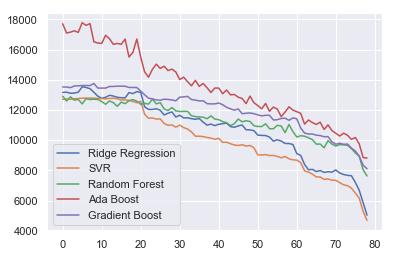

In [10]:
p = cv_results.plot()